<a href="https://www.kaggle.com/code/averma111/tabular-vector-borne-tensorflow?scriptVersionId=126737671" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


## Reading the train data using pandas


In [3]:
ROOT_PATH ='/kaggle/input/playground-series-s3e13'
train = pd.read_csv(ROOT_PATH+'/train.csv')
train.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


## Check the summary of the train dataset

In [4]:
def dataset_summary(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary['Null'] = df.isnull().sum()
    summary['Unique'] = df.nunique()
    summary['min'] = df.min()
    summary['median'] = df.median()
    summary['max'] = df.max()
    summary['mean'] = df.mean()
    summary['std'] = df.std()
    
    return summary

In [8]:
dataset_summary(train)

,dtypes,Null,Unique,min,median,max,mean,std
id,int32,0,707,0,353.0,706,353.000000,204.237607
sudden_fever,int32,0,2,0,1.0,1,0.503536,0.500341
headache,int32,0,2,0,0.0,1,0.449788,0.497825
mouth_bleed,int32,0,2,0,0.0,1,0.459689,0.498725
nose_bleed,int32,0,2,0,0.0,1,0.487977,0.500209
...,...,...,...,...,...,...,...,...
ulcers,int32,0,2,0,0.0,1,0.144272,0.351614
toenail_loss,int32,0,2,0,0.0,1,0.137199,0.344301
speech_problem,int32,0,2,0,0.0,1,0.032532,0.177533
bullseye_rash,float64,0,2,0.0,0.0,1.0,0.031117,0.173758


## Observation from summary of train dataset
* There are no null value in any columns
* Apart from Id and prognosis all the columns are categorial
* The categorical datatype is float64

In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     707 non-null    int64  
 1   sudden_fever           707 non-null    float64
 2   headache               707 non-null    float64
 3   mouth_bleed            707 non-null    float64
 4   nose_bleed             707 non-null    float64
 5   muscle_pain            707 non-null    float64
 6   joint_pain             707 non-null    float64
 7   vomiting               707 non-null    float64
 8   rash                   707 non-null    float64
 9   diarrhea               707 non-null    float64
 10  hypotension            707 non-null    float64
 11  pleural_effusion       707 non-null    float64
 12  ascites                707 non-null    float64
 13  gastro_bleeding        707 non-null    float64
 14  swelling               707 non-null    float64
 15  nausea

In [6]:
train[train.columns.tolist()[0:64]] = train[train.columns.tolist()[0:64]].astype('int32')

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a column transformer
ct= make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),train.columns)
)

# Create X and y
X = train.drop(columns=['id','prognosis'],axis=1)
y = train['prognosis']

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# Split between train and test dataset

X_train,X_test,y_train,y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=42)

## Experiment-1 Basic Tensorflow Model

In [ ]:
#!pip install upgrade  tensorflow_ranking

In [48]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100,input_shape=[64], activation='relu'),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_1.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    #metrics =[tensorflow_ranking.keras.metrics.MeanAveragePrecisionMetric()]
    metrics=['mae']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [49]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 100)               6500      
                                                                 
 dense_23 (Dense)            (None, 50)                5050      
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [51]:
history=model_1.fit(X_train,y_train,epochs=300,verbose=1,callbacks=[callback])

Epoch 1/300
18/18 [==============================] - 1s 3ms/step - loss: 3.0052 - mae: 3.0052
Epoch 2/300
18/18 [==============================] - 0s 3ms/step - loss: 2.4045 - mae: 2.4045
Epoch 3/300
18/18 [==============================] - 0s 3ms/step - loss: 2.0953 - mae: 2.0953
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 1.9244 - mae: 1.9244
Epoch 5/300
18/18 [==============================] - 0s 3ms/step - loss: 1.8364 - mae: 1.8364
Epoch 6/300
18/18 [==============================] - 0s 3ms/step - loss: 1.8188 - mae: 1.8188
Epoch 7/300
18/18 [==============================] - 0s 3ms/step - loss: 1.5892 - mae: 1.5892
Epoch 8/300
18/18 [==============================] - 0s 3ms/step - loss: 1.5136 - mae: 1.5136
Epoch 9/300
18/18 [==============================] - 0s 2ms/step - loss: 1.3784 - mae: 1.3784
Epoch 10/300
18/18 [==============================] - 0s 3ms/step - loss: 1.2581 - mae: 1.2581
Epoch 11/300
18/18 [==============================] - 0s 3m

In [52]:
model_1.evaluate(X_test,y_test)

5/5 [==============================] - 0s 4ms/step - loss: 2.3994 - mae: 2.3994


[2.399366855621338, 2.399366855621338]

Text(0.5, 0, 'Epochs')

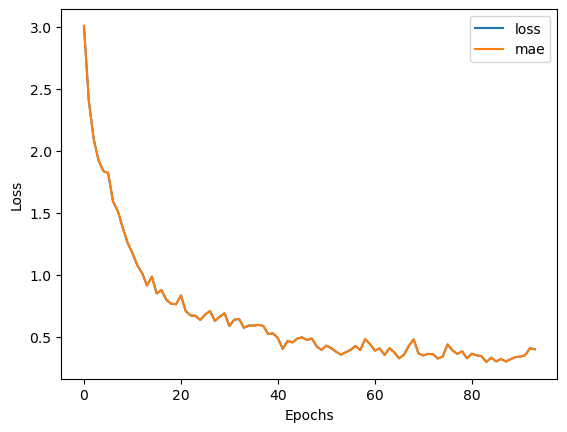

In [53]:
# Plot history also known as loss curve or training curve 
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")